In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [3]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [4]:
datasize = 100
max_document_length = 256

index = -1
train_docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if (not status) or (max_document_length is not None and len(doc) > max_document_length):
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        train_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [5]:
index = 0
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: rec.autos
apparently you re not a woman my husband hate the auto door lock feel safer in a car that lock easily in addition to watch around in a seclude spot etc have my key ready to open the door so i m


In [6]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[100, 100, 100, 100]


In [7]:
print(f"there are {len(train_docs)} docs")

there are 400 docs


### Initialize Vectorizer

In [8]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(train_docs)

vocabulary = vectorizer.get_feature_names()
print("word_count is", len(vocabulary))

word_count is 2727


### Prepare Datatset

In [9]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()

total_num_of_documents = len(train_doc_vectors)
print(f"{total_num_of_documents} train_docs")

400 train_docs


### Word-Word Ratio

In [356]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_doc_frequency = (word_freq_in_doc > 0).astype(int)
word_doc_frequency_norm = (word_freq_in_doc.T / word_freq_in_doc.sum(1)).T
probability = word_doc_frequency.sum(0) / len(train_doc_vectors)

for word in tqdm(vocabulary):
    pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0) / total_num_of_documents
    pmi = np.log2(pxy / (probability[word] * probability))
    
    pmi = pmi.replace([np.inf, -np.inf], 0)
    pmi = pmi.fillna(0)
    
    dev = pmi - pmi.min()
    word_word_co[word] = dev / dev.sum()

# word_word_co = (word_word_co.T / word_word_co.sum(1)).T
print(f"word_word_co has shape {word_word_co.shape}")

c:\users\christian\documents\christian\work\python\cyberspace\topic_modeler\venv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



word_word_co has shape (2727, 2727)


In [357]:
word_word_co.head()

,00,000,0098,020359,031349,0878,0b1fatransfer,10,1000,10k,...,you,your,yours,yourself,yourselves,ypu,yup,zbib,zeuge,zuma
00,0.070043,0.000312,0.000000,0.000000,0.000000,0.0,0.0,0.002954,0.000284,0.00033,...,0.000298,0.000294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.000000,0.003021,0.000000,0.000000,0.000000,0.0,0.0,0.002210,0.000284,0.00033,...,0.000490,0.000490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0098,0.000000,0.000312,0.054181,0.000000,0.000000,0.0,0.0,0.000329,0.000284,0.00033,...,0.000298,0.000294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020359,0.000000,0.000312,0.000000,0.040777,0.000000,0.0,0.0,0.000329,0.000284,0.00033,...,0.000298,0.000294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
031349,0.000000,0.000312,0.000000,0.000000,0.048983,0.0,0.0,0.000329,0.000284,0.00033,...,0.000557,0.000811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate Word Trust ratio

In [358]:
word_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(word_word_co.T, base=2)), columns=[0], index=vocabulary)[0]

pivot_entropy = word_entropy
pivot_entropy = (pivot_entropy - pivot_entropy.mean())

word_weight = pd.DataFrame(data=gaussian(pivot_entropy), columns=[0], index=vocabulary)[0]

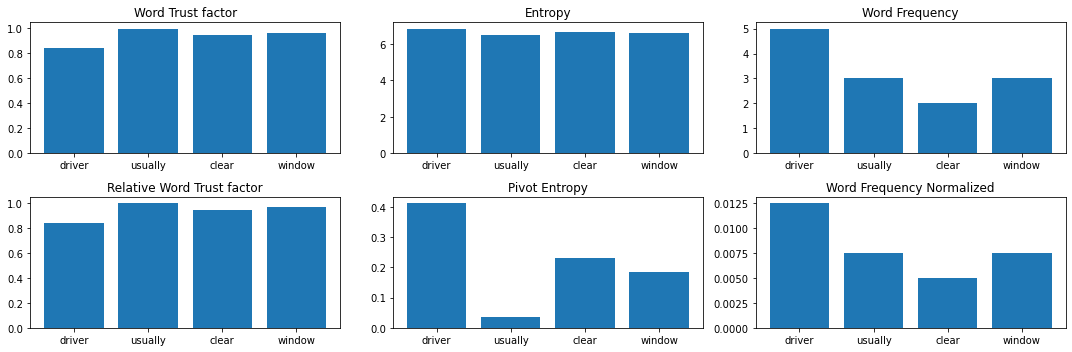

In [359]:
# words = ["israel", "the", "algorithm", "program", "and"]
words = ["driver", "usually", "clear", "window"]
# words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]

fig = plt.figure(figsize=(15,5), tight_layout=True)
ax11 = fig.add_subplot(231)
ax12 = fig.add_subplot(232)
ax13 = fig.add_subplot(233)
ax21 = fig.add_subplot(234)
ax22 = fig.add_subplot(235)
ax23 = fig.add_subplot(236)

ax11.set_title(f"Word Trust factor")
ax11.bar(words, word_weight[words])

ax12.set_title(f"Entropy")
ax12.bar(words, word_entropy[words])

ax13.set_title(f"Word Frequency")
ax13.bar(words, word_freq_in_doc.sum(0)[words])

word_weight = word_weight / word_weight.max()

ax21.set_title(f"Relative Word Trust factor")
ax21.bar(words, word_weight[words])

ax22.set_title(f"Pivot Entropy")
ax22.bar(words, abs(pivot_entropy)[words])

ax23.set_title(f"Word Frequency Normalized")
ax23.bar(words, (probability)[words])

plt.show()

In [360]:
word_weight.sort_values(ascending=False).head(5)

reporting     1.0
bias          1.0
propaganda    1.0
goering       1.0
press         1.0
Name: 0, dtype: float64

### Observe word_word_co ratios

In [361]:
wwc = (word_word_co * word_weight)

=== Ploting software against ['driver', 'usually', 'clear', 'window'] ===


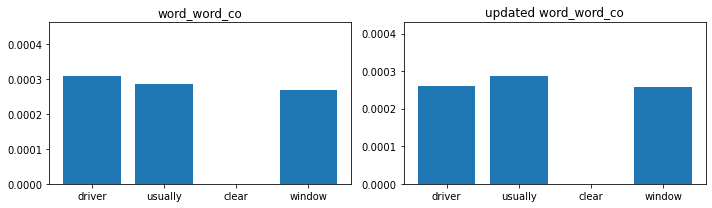

In [362]:
word = "software"

fig = plt.figure(figsize=(10,3), tight_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

print(f"=== Ploting {word} against {words} ===")

values = word_word_co.loc[word][words]
ax1.set_title(f"word_word_co")
ax1.set_ylim(0, 1.5*values.max())
ax1.bar(words, values)

values = wwc.loc[word][words]
ax2.set_title(f"updated word_word_co")
ax2.set_ylim(0, 1.5*values.max())
ax2.bar(words, values)

plt.show()

In [363]:
wwc.loc["war"].sort_values(ascending=False).head(10)

civil       0.072930
war         0.072930
currency    0.072930
coin        0.072930
various     0.034879
require     0.030262
motto       0.008162
50          0.005253
since       0.002067
didn        0.001214
Name: war, dtype: float64

In [364]:
word_word_co.loc["war"].sort_values(ascending=False).head(10)

war         0.089770
currency    0.089770
coin        0.089770
civil       0.089770
various     0.037669
require     0.031299
motto       0.008694
50          0.005601
since       0.002068
didn        0.001658
Name: war, dtype: float64

In [365]:
word_word_co = wwc.copy()

### Update word_word_co with word_word_co

In [366]:
doc_word_distr = word_doc_frequency * word_weight
# doc_word_distr = (doc_word_distr.T / doc_word_distr.sum(1)).T.fillna(0)

In [367]:
doc_index = 13
word_doc_frequency_norm.iloc[doc_index].sort_values(ascending=False).head(10)

be         0.044444
you        0.044444
see        0.044444
to         0.044444
their      0.044444
they       0.044444
middle     0.022222
if         0.022222
them       0.022222
obvious    0.022222
Name: 13, dtype: float64

In [368]:
(doc_word_distr.iloc[doc_index]**probability).sort_values(ascending=False).head(10)

usually    0.999991
method     0.999954
obvious    0.999938
window     0.999741
clear      0.999734
finger     0.999726
extend     0.999174
ahead      0.999174
semi       0.999174
lane       0.999174
dtype: float64

In [369]:
doc_word_distr.iloc[doc_index].sort_values(ascending=False).head(10)

usually    0.998748
obvious    0.993775
method     0.990860
finger     0.972927
window     0.966061
clear      0.948164
hand       0.944700
stick      0.912734
middle     0.883239
driver     0.844138
Name: 13, dtype: float64

In [370]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: rec.autos
i d like to see you use this method on a couple of semi driver if they see you they usually acknowledge by stick their hand out the window with their middle finger extend because it be also obvious to them that there be no clear lane ahead


In [371]:
doc_word_distr.head()

,00,000,0098,020359,031349,0878,0b1fatransfer,10,1000,10k,...,you,your,yours,yourself,yourselves,ypu,yup,zbib,zeuge,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [372]:
for di in range(len(doc_word_distr.index)):
    print(doc_word_distr.iloc[di].sort_values(ascending=False).head(5).index.to_list())
    break

['woman', 'apparently', 'key', 'addition', 'hate']


### Define Latent partitions

In [393]:
# reduction = None
# reduction = "pca"
reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 2
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components, whiten=True)
    x_new = param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    column_values = [doc_word_distr.mean(1), doc_word_distr.std(1)]
    param_values = np.array(column_values).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

distr_params has shape (400, 2)


In [394]:
distr_params.head()

,mean,std
0,0.006526,0.075904
1,0.004478,0.064086
2,0.006650,0.077552
3,0.009059,0.089451
4,0.003167,0.053195


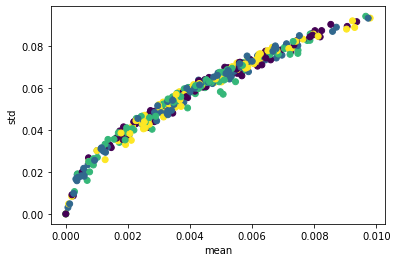

In [395]:
plt.scatter(param_values[:, 0], param_values[:,1], c = label_indices)
plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.show()

### Using Kmeans MiniBatch

In [376]:
num_of_topics = 4

In [377]:
doc_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(doc_word_distr.T, base=2)), columns=[0], index=distr_params.index)[0]

doc_trust_factor = pd.DataFrame(data=gaussian2(doc_entropy), columns=[0], index=distr_params.index)[0]
# doc_trust_factor = pd.DataFrame(data=gaussian2(abs(doc_entropy - doc_entropy.mean())), columns=[0], index=distr_params.index)[0]

doc_trust_factor = doc_trust_factor / doc_trust_factor.sum()

In [378]:
doc_trust_factor.sort_values(ascending=False)

254    0.039442
83     0.039442
253    0.039442
56     0.039372
159    0.034845
         ...   
37     0.000305
30     0.000303
336    0.000286
287    0.000285
395    0.000284
Name: 0, Length: 400, dtype: float64

In [379]:
doc_word_distr.loc[263].sort_values(ascending=False).head(10)

site       0.999987
our        0.999961
taurus     0.996664
company    0.995407
later      0.991737
nice       0.986117
real       0.981899
buy        0.970967
every      0.933355
20         0.879716
Name: 263, dtype: float64

In [380]:
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)
# kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params, sample_weight=distr_params.std(1))
# kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params, sample_weight=doc_trust_factor)

In [381]:
# kmeans_model = MiniBatchKMeans(n_clusters=num_of_topics, random_state=0)

# num_of_iterations = 256

# num_of_samples = len(distr_params)
# batch_size = num_of_samples // 2

# for i in tqdm(range(num_of_iterations)):
#     indices = np.random.randint(num_of_samples, size=batch_size)
    
#     kmeans_model.partial_fit(distr_params.iloc[indices])

# kmeans_model.cluster_centers_.shape

In [382]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)
wtf = gaussian(normalize(dist, norm="l1", axis=1))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

dist has shape (400, 4), predicted_labels has shape (400,)


In [383]:
# wtf

In [384]:
Counter(predicted_labels)

Counter({2: 129, 0: 136, 3: 38, 1: 97})

In [385]:
voc_array = np.array(vocabulary)

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(doc_word_distr.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    xv = (doc_word_distr.T * wtf[:, topic]).T.iloc[indices]
    xvc = (xv > 0).sum(0)
    print((xv.sum(0) * calculate_trust_ratio(xvc) / xvc).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])
    get_topwords(topic)
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))
    get_topwords(topic)

In [386]:
get_top(0)

Counter({'alt.atheism': 42, 'talk.politics.mideast': 37, 'sci.space': 33, 'rec.autos': 24})
wonder       0.058590
mean         0.051366
something    0.048777
thanks       0.046417
god          0.043584
please       0.043572
tell         0.042593
day          0.039111
sound        0.037387
those        0.036853
dtype: float64


In [387]:
get_top(1)

Counter({'rec.autos': 26, 'alt.atheism': 26, 'sci.space': 24, 'talk.politics.mideast': 21})
must      0.040154
thanks    0.037122
let       0.036559
see       0.036206
before    0.032528
our       0.030839
claim     0.030764
name      0.030390
ll        0.030103
again     0.029550
dtype: float64


In [388]:
get_top(2)

Counter({'rec.autos': 45, 'sci.space': 38, 'talk.politics.mideast': 26, 'alt.atheism': 20})
back      0.048497
course    0.042471
left      0.041778
israel    0.041368
way       0.041270
put       0.041139
two       0.040000
him       0.039121
ok        0.037199
isn       0.036265
dtype: float64


In [389]:
get_top(3)

Counter({'talk.politics.mideast': 16, 'alt.atheism': 12, 'rec.autos': 5, 'sci.space': 5})
back       0.070635
israel     0.046835
up         0.039635
oh         0.026253
mr         0.026118
delete     0.025948
hear       0.025932
people     0.025867
perhaps    0.025813
stupid     0.025788
dtype: float64


### LDA